# Reconfiguração de kits cirúrgicos usando redes complexas

Inicialmente, precisamos importar as bibliotecas que serão utilizados para o processamento das informações e adicionaremos configurações para a exibição de gráficos e tabelas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import networkx as nx
from itertools import tee
import community

plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 40)

SEED = 13
np.random.seed(SEED)

## Base de Dados

Abrimos a base de dados e metadados associados.

In [2]:
dataset = pd.read_csv("./Dataset/base_gasto_de_sala v2.csv")
metadados = pd.read_csv("./Dataset/Metadados.txt")

A base de dados guarda todos os materiais utilizados para diversas cirurgias. Ela foi construída a partir da junção de múltiplas tabelas com informações sobre convenios, especialidades cirúrgicas, materiais e descrições. Devido a junção, a mesma cirurgia aparece diversas vezes na tabela, variando de acordo com o número de insumos utilizados.

As seguintes infromações ão armazenadas:

In [3]:
metadados.head(30)

,Codigo,Significado
0,CD_CONVENIO,Codigo do convenio
1,NM_CONVENIO,Nome do convenio
2,CD_AVISO_CIRURGIA,Codigo unico da cirurgia (Identific...
3,DT_REALIZACAO,Data de realizacao da cirurgia
4,CD_CIRURGIA_AVISO,Codigo subcirurgia (Identifica as s...
5,CD_CIRURGIA,Codigo da cirurgia
6,DS_CIRURGIA,Descricao da cirurgia
7,SN_PRINCIPAL,Nao definido
8,CD_CID,Nao definido
9,DS_CID,Nao definido


In [4]:
dataset = dataset.sort_values(by=["DT_REALIZACAO"])
dataset.head(5)

,CD_CONVENIO,NM_CONVENIO,CD_AVISO_CIRURGIA,DT_REALIZACAO,CD_CIRURGIA_AVISO,CD_CIRURGIA,DS_CIRURGIA,SN_PRINCIPAL,CD_CID,DS_CID,CD_ESPECIALID,DS_ESPECIALID,CD_PRODUTO,DS_PRODUTO,CD_ESPECIE,DS_ESPECIE,CD_CLASSE,DS_CLASSE,CD_SUB_CLA,DS_SUB_CLA,DS_UNIDADE_REFERENCIA,CD_PRODUTO_MESTRE,DS_PRODUTO_MESTRE,CD_ESPECIE_MESTE,DS_ESPECIE_MESTRE,CD_CLASSE_MESTRE,DS_CLASSE_MESTRE,CD_SUB_CLA_MESTRE,DS_SUB_CLA_MESTRE,QT_MOVIMENTACAO
171087,1,SUS - INTERNACAO,34544,01/01/17 08:17:49,56065,784,FRATURA UMERO - TRAT CIRURGICO,N,V296,MOTOCICLISTA NAO ESPECIFICADO TRAUMA...,33.0,ORTOPEDIA/TRAUMATOLOGIA,8076,"FOSF DE DEXAMETASONA (G) 4MG/ML 2,5M...",1,DROGAS E MEDICAMENTOS,1,SISTEMA ANALGESIA E ANESTESIA,2,ANTIINFLAMATORIOS,AMPOLA,8075.0,"FOSFATO DE DEXAMETASONA 4MG/ML 2,5ML...",1.0,DROGAS E MEDICAMENTOS,1.0,SISTEMA ANALGESIA E ANESTESIA,2.0,ANTIINFLAMATORIOS,1.0
429455,1,SUS - INTERNACAO,34544,01/01/17 08:17:49,56063,2450,FRATURA TIBIAL,S,V296,MOTOCICLISTA NAO ESPECIFICADO TRAUMA...,33.0,ORTOPEDIA/TRAUMATOLOGIA,1003,P.V.P.I TINTURA ALMOTOLIA 100 ML - R...,2,MATERIAIS HOSPITALARES,8,PRODUTO QUIMICOS,4,TINTURAS E SOLUCOES,FRASCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9481,1,SUS - INTERNACAO,34544,01/01/17 08:17:49,56063,2450,FRATURA TIBIAL,S,V296,MOTOCICLISTA NAO ESPECIFICADO TRAUMA...,33.0,ORTOPEDIA/TRAUMATOLOGIA,11666,ESMERON 10MG/ML 5ML - IV - SCHERING,1,DROGAS E MEDICAMENTOS,1,SISTEMA ANALGESIA E ANESTESIA,15,MIORRELAXANTES CENTRAIS/PERIFE,FRASCO/AMPOLA,8228.0,BROMETO DE ROCURONIO 10MG/ML 5ML - I...,1.0,DROGAS E MEDICAMENTOS,1.0,SISTEMA ANALGESIA E ANESTESIA,15.0,MIORRELAXANTES CENTRAIS/PERIFE,1.0
119021,1,SUS - INTERNACAO,34544,01/01/17 08:17:49,56065,784,FRATURA UMERO - TRAT CIRURGICO,N,V296,MOTOCICLISTA NAO ESPECIFICADO TRAUMA...,33.0,ORTOPEDIA/TRAUMATOLOGIA,5185,PARAFUSO ESPONJOSO RL 6.5X60,7,OPME´S,1,OPME´S CONSIGNADOS P/ CIRURGIA,2,OPME´S EM ORTOPEDIA,UNIDADE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
669524,1,SUS - INTERNACAO,34544,01/01/17 08:17:49,56065,784,FRATURA UMERO - TRAT CIRURGICO,N,V296,MOTOCICLISTA NAO ESPECIFICADO TRAUMA...,33.0,ORTOPEDIA/TRAUMATOLOGIA,264,COMPRESSA CIRURGICA 25CM X 28CM ESTE...,2,MATERIAIS HOSPITALARES,5,TEXTEIS,2,COMPRESSAS,PACOTE,15251.0,COMPRESSA CIRURGICA 25CM X 28CM ESTE...,2.0,MATERIAIS HOSPITALARES,5.0,TEXTEIS,2.0,COMPRESSAS,9.0


In [5]:
print("Tamanho base de dados:", len(dataset))
print("Colunas:", dataset.columns)

Tamanho base de dados: 700741
Colunas: Index(['CD_CONVENIO', 'NM_CONVENIO', 'CD_AVISO_CIRURGIA', 'DT_REALIZACAO',
       'CD_CIRURGIA_AVISO', 'CD_CIRURGIA', 'DS_CIRURGIA', 'SN_PRINCIPAL',
       'CD_CID', 'DS_CID', 'CD_ESPECIALID', 'DS_ESPECIALID', 'CD_PRODUTO',
       'DS_PRODUTO', 'CD_ESPECIE', 'DS_ESPECIE', 'CD_CLASSE', 'DS_CLASSE',
       'CD_SUB_CLA', 'DS_SUB_CLA', 'DS_UNIDADE_REFERENCIA',
       'CD_PRODUTO_MESTRE', 'DS_PRODUTO_MESTRE', 'CD_ESPECIE_MESTE',
       'DS_ESPECIE_MESTRE', 'CD_CLASSE_MESTRE', 'DS_CLASSE_MESTRE',
       'CD_SUB_CLA_MESTRE', 'DS_SUB_CLA_MESTRE', 'QT_MOVIMENTACAO'],
      dtype='object')


## Análise Exploratória

O objetivo dessa seção é explorar superficialmente as informações contidas na base de dados através de seimples estatísticas. Como a base possui múltiplas entradas para informações semelhantes, é conveniente separá-la em  múltiplas tabelas.........

### Ocorrência especialidades

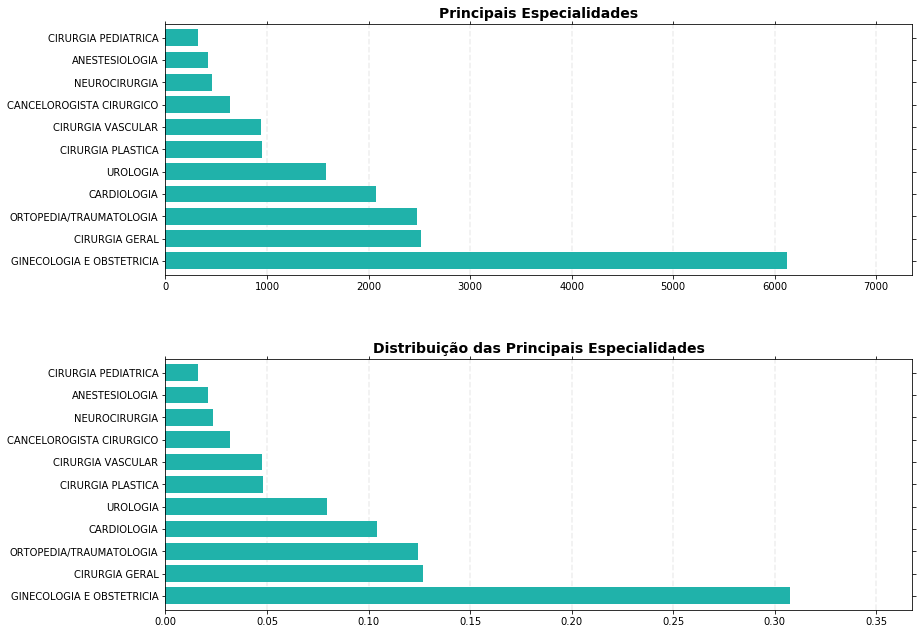

In [6]:
def plot_bar(data, title, x_label, y_label, position):
    ax = data.plot(kind='barh', figsize=(14, 10), color='lightseagreen', zorder=2, width=0.75, ax=position)

    ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=1, color='#eeeeee', zorder=1)
    
    # Labels
    ax.set_title(title, weight='bold', size=14)
    ax.set_xlabel(x_label, labelpad=20, weight='bold', size=12)
    ax.set_ylabel(y_label, labelpad=20, weight='bold', size=12)
    
    return ax
    

cirurgias_unicas = dataset.drop_duplicates(subset=["CD_AVISO_CIRURGIA"])

# Conjunto de especialidades
especialidades = set(dataset["DS_ESPECIALID"].unique())

# Distribuicao de acordo com as especialidades
especialidades_dist = cirurgias_unicas["DS_ESPECIALID"].value_counts()
especialidades_dist = especialidades_dist/len(cirurgias_unicas)
especialidades_dist_plot = especialidades_dist[especialidades_dist > 0.015]

# Valores absolutos
especialidades_abs = cirurgias_unicas["DS_ESPECIALID"].value_counts()
especialidades_abs_plot = especialidades_abs[especialidades_abs > 300]

# Plotar
fig, axes = plt.subplots(nrows=2)

plot_bar(especialidades_abs_plot, "Principais Especialidades", "", "", axes[0])
plot_bar(especialidades_dist_plot, "Distribuição das Principais Especialidades", "", "", axes[1])

    # Espaço entre imagens
fig.tight_layout(pad=5.0)

# Salvar imagem
# fig.savefig('especialidades.png', bbox_inches='tight')
# https://mode.com/example-gallery/python_horizontal_bar/

In [7]:
print("Numero de Especialidades:", len(especialidades))
print("Numero de Cirurgias:", especialidades_abs.sum())

print(tabulate(especialidades_dist.to_frame(), headers=["Especialidade", "Porcentagem"], tablefmt='psql'))
print(tabulate(especialidades_abs.to_frame(), headers=["Especialidade", "Quantidade"], tablefmt='psql'))

Numero de Especialidades: 39
Numero de Cirurgias: 19903
+--------------------------------+---------------+
| Especialidade                  |   Porcentagem |
|--------------------------------+---------------|
| GINECOLOGIA E OBSTETRICIA      |   0.307426    |
| CIRURGIA GERAL                 |   0.126608    |
| ORTOPEDIA/TRAUMATOLOGIA        |   0.124297    |
| CARDIOLOGIA                    |   0.104301    |
| UROLOGIA                       |   0.079381    |
| CIRURGIA PLASTICA              |   0.0479803   |
| CIRURGIA VASCULAR              |   0.0475281   |
| CANCELOROGISTA CIRURGICO       |   0.0320036   |
| NEUROCIRURGIA                  |   0.0232617   |
| ANESTESIOLOGIA                 |   0.0209003   |
| CIRURGIA PEDIATRICA            |   0.0161274   |
| CIRURGIA CARDIOVASCULAR        |   0.0112038   |
| OFTALMOLOGIA                   |   0.0111535   |
| OTORRINOLARINGOLOGIA           |   0.00783762  |
| ODONTOLOGIA C.TRAUM.B.M.F.     |   0.00688304  |
| MASTOLOGIA              

#### Ginecologia e Obstetricia

In [8]:
ginecologia = cirurgias_unicas[cirurgias_unicas["DS_ESPECIALID"] == "GINECOLOGIA E OBSTETRICIA"]
ginecologia_cnt = ginecologia["DS_CIRURGIA"].value_counts()

print(tabulate(ginecologia_cnt.to_frame(), headers=["Cirurgia", "Valor"], tablefmt='psql'))

+---------------------------------------------------------------------+---------+
| Cirurgia                                                            |   Valor |
|---------------------------------------------------------------------+---------|
| CESARIANA - FETO MULTIPLO                                           |    2305 |
| PARTO NORMAL                                                        |    1321 |
| CESARIANA - FETO UNICO                                              |    1226 |
| CURETAGEM POS ABORTO                                                |     456 |
| HISTERECTOMIA ABDOMINAL                                             |     212 |
| CURETAGEM SEMIOTICA COM OU SEM DILATACAO                            |     126 |
| CESARIANA COM LAQUEADURA TUBARIA                                    |      39 |
| SALPINGECTOMIA UNI OU BILATERAL                                     |      32 |
| COLPOPERINEOPLASTIA POSTERIOR                                       |      31 |
| TRATAMENTO CIR

## Construindo a rede

O grafo G = {V, E} é ponderado e não direcionado, onde V reprsenta o conjunto dos vértices e E o conjunto das arestas. Cada elemento _v_ pertencente a __V__ representa um insumo utilizado em uma cirurgia. Cada aresta _e_ pertencente a __E__ é um par {_a_, _b_} representando o uso dos insumos na mesma operação. O peso _p_ da aresta é igual a $p = x/z$, onde __x__ é o número de operações que utilizaram os insumos _a_ e _b_, já __z__ é o número de operações que usaram _a_ ou _b_. 


Inicialmente, devido a grande quantidade de dados, iremos separar a especialidade ginecológica e construir a rede a partir das cesarianas de feto único (código = 3101). Foram realizadas 6207 cirugias cesarianas de feto único, englobando 6315 subcirurgias e utilizando 329 insumos únicos.

In [9]:
ginecologia = dataset[dataset["DS_ESPECIALID"] == "GINECOLOGIA E OBSTETRICIA"]
cesariana = ginecologia[ginecologia["DS_CIRURGIA"] == "CESARIANA - FETO UNICO"]

print("# Cirugias Realizadas",len(ginecologia["CD_AVISO_CIRURGIA"].unique()))
print("# Subcirurgias", len(ginecologia["CD_CIRURGIA_AVISO"].unique()))
print("# Insumos únicos", len(cesariana["CD_PRODUTO"].unique()))
print("# Insumos utilizados", len(cesariana))

# Cirugias Realizadas 6207
# Subcirurgias 6315
# Insumos únicos 329
# Insumos utilizados 48744


Construimos então uma tabela onde cada linha representa uma cirurgia e cada coluna um insumo. Se o insumo for utilizado na cirurgia, será indicado como 1.

In [10]:
# Separa o codigo dos produtos e as cirurgias
cd_produtos = cesariana["CD_PRODUTO"].unique()
cirurgias = cesariana["CD_CIRURGIA_AVISO"].unique()

# Constroi o dataFrame indexado pelas cirurgias, cujas colunas sao os produtos
cir_prod = pd.DataFrame(columns=cd_produtos)
cir_prod.insert(0, "Cirurgia", cirurgias)
cir_prod.set_index("Cirurgia", inplace=True)
cir_prod.fillna(0, inplace=True)

# Preenche o dataFrame
for i in range(len(cesariana)):
    cir = cesariana.iloc[i]["CD_CIRURGIA_AVISO"]
    prod = cesariana.iloc[i]["CD_PRODUTO"]
    cir_prod.at[cir, prod] = 1
    
# Adiciona coluna e linha final com somas
cir_prod["Soma"] = cir_prod.sum(axis=1)
row = cir_prod.sum(axis=0)
row.name = "Soma"
cir_prod = cir_prod.append(row)

# Removendo Nan
cir_prod = cir_prod.fillna(0)

In [11]:
cir_prod.head(5)

,8076,17365,8914,8317,16630,12533,1212,7908,25,13733,1207,1416,16629,447,381,7889,1214,14582,1218,1205,731,11,11763,38,9187,8575,9301,14125,8122,587,1210,383,11911,267,8723,506,17930,633,1311,20,8438,17780,8078,13,8677,17685,496,11155,515,10,8175,641,16632,16746,545,371,593,622,11638,8545,741,927,7936,8681,14583,757,7909,11914,12166,8077,264,12056,1209,1211,11646,8913,14491,14107,456,8680,8406,1509,473,1220,11712,8328,8470,12588,16631,8121,12266,693,9005,16628,12534,320,12214,12225,8409,13375,11981,12226,8546,8676,13068,476,8964,13349,8581,18555,17747,18350,14227,8553,575,14815,44,8194,8487,9099,7887,8467,14412,7892,596,14410,608,19218,11820,10850,17767,8440,8881,11916,475,14088,16747,8435,11639,8557,17501,17658,48,483,9100,580,17742,7809,13951,9930,8582,14056,1501,12028,17748,11945,10851,534,3,8937,8432,12974,634,8489,318,8373,12559,8458,8433,478,8124,737,9352,17,16608,78,528,8579,11635,14480,8540,11910,142,9108,8461,527,1731,7982,64,7853,7912,1706,9715,14648,8475,285,11425,8321,60,18969,12830,8899,14042,15740,1012,1,8965,8960,9713,9790,616,7854,8474,415,8740,8966,8786,8490,8742,8219,8787,11980,9173,10187,16749,8185,11631,739,8577,8535,12497,12153,15769,17933,14545,16,8015,481,11924,18076,7981,16365,7927,8496,8221,17474,1413,9218,11909,8728,8439,8529,8371,9070,9623,9487,8454,8079,1055,7917,9069,23,14571,9097,9112,8460,10182,1650,8413,12013,11921,10071,8498,11745,8608,8452,18052,8880,8463,12066,18034,484,9482,1196,16748,14256,18805,9148,17941,471,612,8940,11824,1297,8736,662,16625,12870,8172,11850,8970,8453,11680,10188,16984,15722,8375,14431,11992,11423,224,8365,11666,17931,1206,8734,8963,14492,15,81,12223,1312,30,16282,8900,8188,16022,8014,7935,Soma
Cirurgia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
88173,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41
88184,0,0,1,1,1,0,1,1,1,1,0,0,1,1,0,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41
88195,0,0,1,1,1,0,1,1,1,1,0,0,1,1,0,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Preparamos lista de arestas com seus pesos:

In [12]:
temp = cir_prod[0:len(cir_prod)-1] # Tabela sem a ultima linha

edges = list() # Lista de edges
for i in range(len(cd_produtos)):
    for j in range(i,len(cd_produtos)):
        equip_i = cd_produtos[i]
        equip_j = cd_produtos[j]
        
        # Tabela onde os dois insumos sao utilizados juntos
        same_use = (temp[equip_i] == 1) & (temp[equip_j] == 1)
        
        # Se eles forem utilizados juntos
        if same_use.any(axis=None):
            # W = num/den
            # Cirurgias que utilizam equip_i & equip_j
            num = len(same_use[same_use == True]) 
            
            # Cirurgias que utilizam equip_i | equip_j -> AUB = A + B - A∩B
            den = cir_prod.loc["Soma"][equip_i] + cir_prod.loc["Soma"][equip_j] - num
            
            edges.append((equip_i, equip_j, 10*num/den))

Construimos o grafo:

In [13]:
network = nx.Graph()
network.add_weighted_edges_from(edges)

### Visualizando a rede

In [7]:
# Posicao dos nos
#     circular_layout
#     kamada_kawai_layout
#     spring_layout > parecido com kamada_kawai, mas traz uma profundidade um pouco estranha
#     spiral_layout > bonito, mas estranho

# Cor dos nos
# Cor das arestas

def plot_network(G, title, save=False):
    pos = nx.kamada_kawai_layout(G)
    
    deg = dict(G.degree)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightseagreen', nodelist=deg.keys(), node_size=[11*np.log(v) for v in deg.values()])
    
    edges_norm = list()

    for u,v in G.edges():
        edge = G.get_edge_data(u,v)
        edges_norm.append(edge['weight'])

    min_val = min(edges_norm)
    max_val = max(edges_norm)

    edges_norm = (edges_norm-min_val)/(max_val-min_val)
    
    nx.draw_networkx_edges(G, pos, alpha=0.25, width=edges_norm)
    
    
    if save:
        plt.savefig("Images/{}".format(title))
    else:
        plt.title(title, fontsize=20)
    
    plt.show()
    

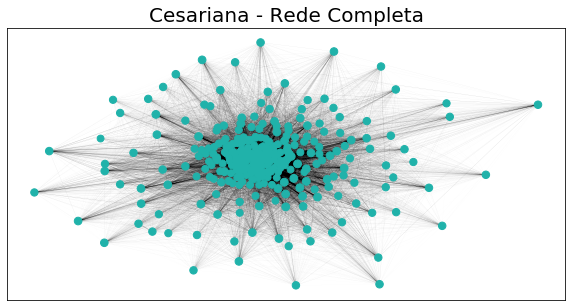

In [15]:
plot_network(network, "Cesariana - Rede Completa", False)

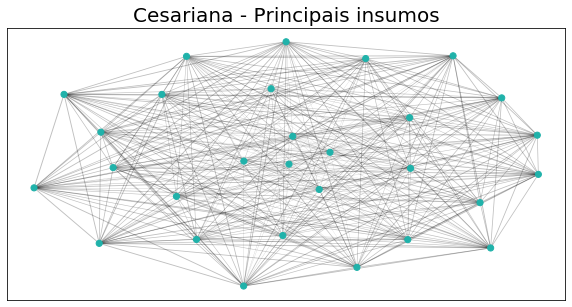

In [16]:
nodes = network.degree()

to_plot = list()
for node in nodes:
    if node[1] > 275:
        to_plot.append(node[0])

sub_graph = network.subgraph(to_plot)

plot_network(sub_graph, "Cesariana - Principais insumos", False)

### Propriedades da Rede

Com a rede em mãos, é interessante avaliar algumas de suas propriedades antes de detectar comunidades. Iremos avaliar:
    - Número de componentes
    - Distribuição de grau
    - Grau medio
    - Transitividade    

In [17]:
n_edges = len(network.edges())
n_nodes = len(network.nodes())

print("Numero de arestas:", n_edges)
print("Numero de nos:", n_nodes)
print("Media de arestas/nos", n_edges/n_nodes)

Numero de arestas: 20607
Numero de nos: 329
Media de arestas/nos 62.63525835866261


#### Número de Componentes

In [18]:
print("Número de componentes: ", nx.number_connected_components(network))

Número de componentes:  1


#### Distribuição de Grau

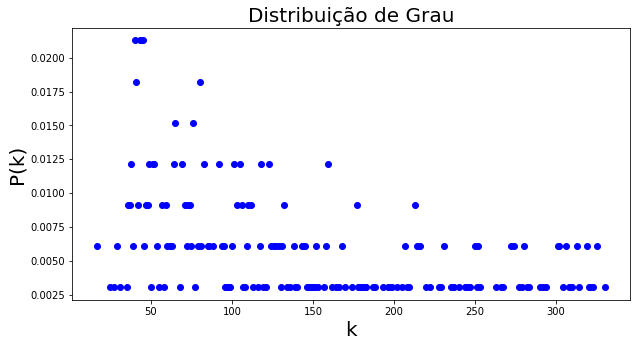

In [19]:
degrees = dict(network.degree())

deg_dist = dict()

for node, degree in degrees.items():
    if degree in deg_dist:
        deg_dist[degree] += 1
    else:
        deg_dist[degree] = 1
        
keys = list(deg_dist.keys())
Pk = list(deg_dist.values())
Pk = [i/sum(Pk) for i in Pk]

fig = plt.subplot(1,1,1)
plt.plot(keys, Pk,'bo')
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição de Grau", fontsize=20)

plt.savefig("Images/Distribuição de grau")
plt.show()

#### Grau medio

In [20]:
avg_deg = np.mean(list(degrees.values()))
print("Grau Medio:", avg_deg)

Grau Medio: 125.27051671732522


#### Variancia

In [13]:
def momment_of_degree_distribution(G,m):
    M = 0
    n = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/n
    return M

In [22]:
primeiro_momento = momment_of_degree_distribution(network, 1)
segundo_momento = momment_of_degree_distribution(network, 2)

variancia = segundo_momento - primeiro_momento**2

print("Variancia: ", variancia)
desvio_amostral = (variancia*len(network)/(len(network)-1))**0.5
print("Desvio amostral :", desvio_amostral/(len(network)**0.5)*1.96)

Variancia:  6896.501288790754
Desvio amostral : 8.98738942925616


#### Transitividade

In [23]:
transitivity = nx.transitivity(network)
rd_transitivity = avg_deg/len(network)

print("Transitivity:", transitivity)
print("Random graph transitivity:", rd_transitivity)
print("Ratio:", transitivity/rd_transitivity)
print("Average cluestring:", nx.average_clustering(network))

Transitivity: 0.5897916807328198
Random graph transitivity: 0.38076144898883046
Ratio: 1.5489795048818642
Average cluestring: 0.8235439179099656


## Detecção de comunidades

A detecção de comunidades será feita utilizando o método de Louvain.

### Método de Louvain

... Descrição do algoritmo


### Detectando comunidades

Iremos utilizar algumas funções para facilitar a visualiação dos resultados.

In [24]:
def plot_community(G, partition, pos):
    size = float(len(set(partition.values())))
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = len(list_nodes), node_color = str(count/ size))


    nx.draw_networkx_edges(G, pos, alpha=0.01)
    plt.show()

In [25]:
def plot_graph(G):
    pos = nx.random_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=40)
    
    nx.draw_networkx_edges(G, pos, alpha=0.01)
    plt.show()
    
    return pos

In [26]:
def colapse_graph_communites(G, communities):
    new_graph = nx.Graph()
    new_graph.add_nodes_from(set(communities.values()))
    
    for node in G:
        org = communities[node]
        for adj in G[node]:
            dst = communities[adj]
            new_graph.add_edge(org, dst, weight=0)
        
    for node in G:
        org = communities[node]
        for adj in G[node]:
            dst = communities[adj]
            new_graph[org][dst]["weight"] += G[node][adj]["weight"]/2
    
    return new_graph

Aqui detectamos as comunidades e exibimos os resultados em três momentos: a rede original, a rede com enfase nas comunidades formadas e um novo grafo formado somente pelas comunidades detectadas.

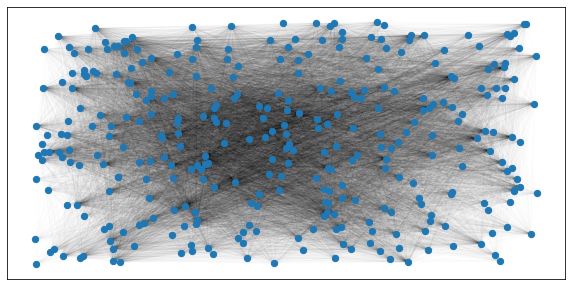

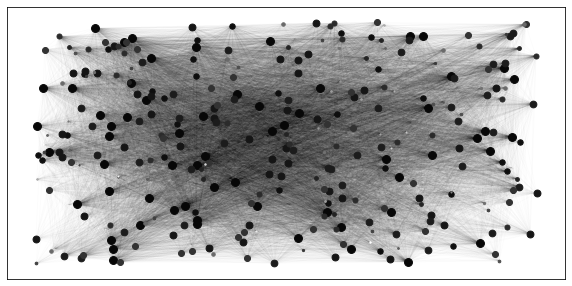

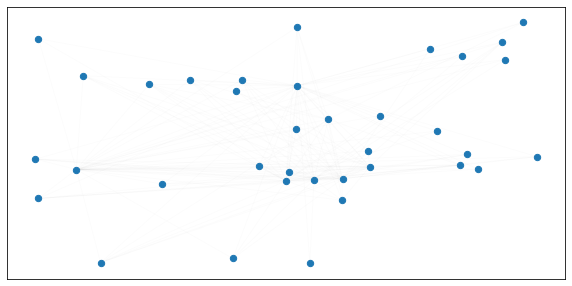

In [27]:
communities = community.best_partition(network)
pos = plot_graph(network)
plot_community(network, communities, pos)

new_graph = colapse_graph_communites(network, communities)

new_pos = plot_graph(new_graph)

Com as comunidades montadas, temos duas opções:
    - Aplicar o algoritmo novamente no novo subgrafo completo
    - Dividir as maiores comunidades formadas em subcomunidades
    
Convem avaliar o tamanho de cada comunidade e os resultados de uma segunda iteração do algoritmo:

#### Distribuição das comunidades

In [62]:
def community_distribution(communities, to_print=True):
    map_com = dict()

    for node, com in communities.items():
        if com in map_com:
            map_com[com].append(node)
        else:
            map_com[com] = [node]

    if to_print:
        for com in sorted(map_com):
            print("Comunidade {} : {}".format(com, len(map_com[com])))
        
    return map_com

In [29]:
communities_map = community_distribution(communities)

Comunidade 0 : 62
Comunidade 1 : 29
Comunidade 2 : 47
Comunidade 3 : 45
Comunidade 4 : 14
Comunidade 5 : 25
Comunidade 6 : 36
Comunidade 7 : 5
Comunidade 8 : 7
Comunidade 9 : 1
Comunidade 10 : 7
Comunidade 11 : 2
Comunidade 12 : 3
Comunidade 13 : 3
Comunidade 14 : 12
Comunidade 15 : 5
Comunidade 16 : 1
Comunidade 17 : 1
Comunidade 18 : 1
Comunidade 19 : 1
Comunidade 20 : 2
Comunidade 21 : 3
Comunidade 22 : 1
Comunidade 23 : 2
Comunidade 24 : 1
Comunidade 25 : 1
Comunidade 26 : 1
Comunidade 27 : 1
Comunidade 28 : 1
Comunidade 29 : 2
Comunidade 30 : 1
Comunidade 31 : 1
Comunidade 32 : 1
Comunidade 33 : 1
Comunidade 34 : 1
Comunidade 35 : 2


#### Segunda iteração do algoritmo


In [30]:
communities2 = community.best_partition(network, partition=communities)

inv = community_distribution(communities2)

Comunidade 0 : 62
Comunidade 1 : 35
Comunidade 2 : 15
Comunidade 3 : 46
Comunidade 4 : 45
Comunidade 5 : 24
Comunidade 6 : 34
Comunidade 7 : 4
Comunidade 8 : 8
Comunidade 9 : 1
Comunidade 10 : 7
Comunidade 11 : 2
Comunidade 12 : 3
Comunidade 13 : 3
Comunidade 14 : 11
Comunidade 15 : 5
Comunidade 16 : 1
Comunidade 17 : 1
Comunidade 18 : 1
Comunidade 19 : 1
Comunidade 20 : 2
Comunidade 21 : 3
Comunidade 22 : 1
Comunidade 23 : 2
Comunidade 24 : 1
Comunidade 25 : 1
Comunidade 26 : 1
Comunidade 27 : 1
Comunidade 28 : 1
Comunidade 29 : 1
Comunidade 30 : 1
Comunidade 31 : 1
Comunidade 32 : 1
Comunidade 33 : 1
Comunidade 34 : 2


As comunidades estão estaveis com relação a modularidade entre elas, ou seja, novas passagens do algoritmo não modificarão os grupos formados.

Iremos então avaliar os impactos de dividir as maiores comunidades formadas em subcomunidades seguindo um limite de 10% dos insumos em um mesmo kit.

In [31]:
small_communities = dict()

for com in communities_map:
    nodes = communities_map[com]
    if len(nodes) / len(network) > 0.1:
        print("Tamanho comunidade original: {}".format(len(nodes)))
        sub_graph = network.subgraph(nodes)

        print("Novas subcomunidades:")
        sub_partition = community.best_partition(sub_graph)
        g = community_distribution(sub_partition)
        small_communities[com] = sub_partition
        
        print("-------------------------")

Tamanho comunidade original: 62
Novas subcomunidades:
Comunidade 0 : 5
Comunidade 1 : 23
Comunidade 2 : 6
Comunidade 3 : 9
Comunidade 4 : 7
Comunidade 5 : 8
Comunidade 6 : 4
-------------------------
Tamanho comunidade original: 47
Novas subcomunidades:
Comunidade 0 : 5
Comunidade 1 : 1
Comunidade 2 : 5
Comunidade 3 : 6
Comunidade 4 : 2
Comunidade 5 : 2
Comunidade 6 : 3
Comunidade 7 : 3
Comunidade 8 : 1
Comunidade 9 : 1
Comunidade 10 : 5
Comunidade 11 : 2
Comunidade 12 : 2
Comunidade 13 : 2
Comunidade 14 : 1
Comunidade 15 : 2
Comunidade 16 : 1
Comunidade 17 : 1
Comunidade 18 : 2
-------------------------
Tamanho comunidade original: 45
Novas subcomunidades:
Comunidade 0 : 5
Comunidade 1 : 3
Comunidade 2 : 1
Comunidade 3 : 6
Comunidade 4 : 3
Comunidade 5 : 1
Comunidade 6 : 3
Comunidade 7 : 3
Comunidade 8 : 3
Comunidade 9 : 3
Comunidade 10 : 2
Comunidade 11 : 2
Comunidade 12 : 1
Comunidade 13 : 2
Comunidade 14 : 4
Comunidade 15 : 1
Comunidade 16 : 2
-------------------------
Tamanho comu

Com excessão da primeira comunidade original, reaplicar o método de louvain nos subgrafos formados pelas comunidades levou a uma atomização dos kits cirurgicos. Tal atomização pode ser entendida como a utilização esporádica dos mesmos elementos em uma unica cirurgia, equanto otros insumos são usados mais frequentemente dentro de um mesmo conjunto.

### Aproveitamento

In [18]:
def community_usage(surgery_product, communities):
    n_communities = len(set(communities.values()))
    
    communities_inv = np.zeros(n_communities)
    for key, value in communities.items():
        communities_inv[value] += 1

    
    # Criando tabela Cirurgia x Comunidades
    surgery_usage = pd.DataFrame(columns=np.arange(n_communities))
    
    # Para cada cirurgia
    for index, surgery in surgery_product.iterrows():
        if index != 'Soma':
            # Conte quantas vezes cada comunidade foi usada
            used_communities = np.zeros(n_communities)

            for product, usage in surgery.items():
                if product != 'Soma' and usage:
                    used_communities[communities[product]] += 1

            surgery_usage.loc[index] = used_communities
        
    # Normalize os valores
    for i in range(n_communities):
        surgery_usage.loc[:,i] = surgery_usage.loc[:,i]/communities_inv[i]
        
    # Adicione as médias das comunidades
    surgery_usage.loc["Media"] = surgery_usage[surgery_usage > 0].mean(axis=0)
    
    # Adicione as médias das cirurgias
    surgery_usage["Media"] = surgery_usage[surgery_usage > 0].mean(axis=1)
    
    return surgery_usage

In [33]:
usage = community_usage(cir_prod, communities)
usage

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,Media
88173,0.500000,0.172414,0.063830,0.022222,0.071429,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165979
88184,0.500000,0.172414,0.042553,0.022222,0.071429,0.040000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141436
88195,0.532258,0.172414,0.000000,0.022222,0.142857,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217438
88199,0.483871,0.172414,0.000000,0.022222,0.142857,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205341
88207,0.580645,0.275862,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.292910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102317,0.596774,0.000000,0.000000,0.044444,0.357143,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332787
88146,0.500000,0.103448,0.000000,0.022222,0.071429,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.2,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179420
88163,0.500000,0.172414,0.000000,0.022222,0.142857,0.080000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183499
88171,0.483871,0.137931,0.106383,0.022222,0.071429,0.040000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143639


In [34]:
print("Utilização Mínima:", usage[0].min())
print("Utilização Máxima:", usage[0].max())

Utilização Mínima: 0.08064516129032258
Utilização Máxima: 0.6935483870967742


In [73]:
def merge_subcommunities(communities, small_communities):
    new_communities = communities.copy()
    
    start_com = len(set(new_communities.values()))+1
    
    for index, sub_community in small_communities.items(): 
        for product, com in sub_community.items():
            new_communities[product] = start_com + com

        start_com += len(set(sub_community.values()))
        

   # Remap new_communities index
    old_index = list(set(new_communities.values()))
    new_index = {old_index[i]:i for i in range(len(old_index))}
    
    for product, com in new_communities.items():
        new_communities[product] = new_index[com]
        
    return new_communities

In [36]:
merged_com = merge_subcommunities(communities, small_communities)

In [37]:
sub_com_usage = community_usage(cir_prod, merged_com)
sub_com_usage

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,Media
88173,0.172414,0.071429,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.826087,0.666667,0.555556,0.285714,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.436120
88184,0.172414,0.071429,0.040000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.782609,0.000000,0.666667,0.142857,0.000000,0.750000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.414264
88195,0.172414,0.142857,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.782609,0.166667,0.777778,0.285714,0.000000,0.750000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.414226
88199,0.172414,0.142857,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.739130,0.166667,0.555556,0.142857,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.385498
88207,0.275862,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.913043,0.333333,0.555556,0.142857,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.508831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102317,0.000000,0.357143,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.826087,0.500000,0.222222,0.857143,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0000,0.0,0.0,0.000

In [38]:
inv = community_distribution(merged_com)

Comunidade 0 : 29
Comunidade 1 : 14
Comunidade 2 : 25
Comunidade 3 : 5
Comunidade 4 : 7
Comunidade 5 : 1
Comunidade 6 : 7
Comunidade 7 : 2
Comunidade 8 : 3
Comunidade 9 : 3
Comunidade 10 : 12
Comunidade 11 : 5
Comunidade 12 : 1
Comunidade 13 : 1
Comunidade 14 : 1
Comunidade 15 : 1
Comunidade 16 : 2
Comunidade 17 : 3
Comunidade 18 : 1
Comunidade 19 : 2
Comunidade 20 : 1
Comunidade 21 : 1
Comunidade 22 : 1
Comunidade 23 : 1
Comunidade 24 : 1
Comunidade 25 : 2
Comunidade 26 : 1
Comunidade 27 : 1
Comunidade 28 : 1
Comunidade 29 : 1
Comunidade 30 : 1
Comunidade 31 : 2
Comunidade 32 : 5
Comunidade 33 : 23
Comunidade 34 : 6
Comunidade 35 : 9
Comunidade 36 : 7
Comunidade 37 : 8
Comunidade 38 : 4
Comunidade 39 : 5
Comunidade 40 : 1
Comunidade 41 : 5
Comunidade 42 : 6
Comunidade 43 : 2
Comunidade 44 : 2
Comunidade 45 : 3
Comunidade 46 : 3
Comunidade 47 : 1
Comunidade 48 : 1
Comunidade 49 : 5
Comunidade 50 : 2
Comunidade 51 : 2
Comunidade 52 : 2
Comunidade 53 : 1
Comunidade 54 : 2
Comunidade 55 :

In [39]:
cnt = 0
for com, products in inv.items():
    if len(products) > 5:
        cnt += 1
        print(com, len(products))
        
print("Porcentagem da comunidades com mais de 5 itens:", cnt/len(inv))

36 7
0 29
33 23
34 6
35 9
1 14
2 25
61 6
37 8
42 6
4 7
6 7
76 8
10 12
80 7
Porcentagem da comunidades com mais de 5 itens: 0.1724137931034483


## Ginecologia e Obstreticia

### Construindo a Rede

In [3]:
ginecologia = dataset[dataset["DS_ESPECIALID"] == "GINECOLOGIA E OBSTETRICIA"]

In [4]:
def build_surgery_product_table(dataset):
    # Separa o codigo dos produtos e as cirurgias
    cd_produtos = dataset["CD_PRODUTO"].unique()
    cirurgias = dataset["CD_CIRURGIA_AVISO"].unique()

    # Constroi o dataFrame indexado pelas cirurgias, cujas colunas sao os produtos
    cir_prod = pd.DataFrame(columns=cd_produtos)
    cir_prod.insert(0, "Cirurgia", cirurgias)
    cir_prod.set_index("Cirurgia", inplace=True)
    cir_prod.fillna(0, inplace=True)

    # Preenche o dataFrame
    for i in range(len(dataset)):
        cir = dataset.iloc[i]["CD_CIRURGIA_AVISO"]
        prod = dataset.iloc[i]["CD_PRODUTO"]
        cir_prod.at[cir, prod] = 1

    # Adiciona coluna e linha final com somas
    cir_prod["Soma"] = cir_prod.sum(axis=1)
    row = cir_prod.sum(axis=0)
    row.name = "Soma"
    cir_prod = cir_prod.append(row)

    # Removendo Nan
    cir_prod = cir_prod.fillna(0)
    
    return cir_prod

def build_graph(surgery_product, dataset):
    temp = surgery_product[0:len(surgery_product)-1] # Tabela sem a ultima linha
    
    cd_produtos = dataset["CD_PRODUTO"].unique()
    
    edges = list() # Lista de edges
    for i in range(len(cd_produtos)):
        for j in range(i,len(cd_produtos)):
            equip_i = cd_produtos[i]
            equip_j = cd_produtos[j]

            # Tabela onde os dois insumos sao utilizados juntos
            same_use = (temp[equip_i] == 1) & (temp[equip_j] == 1)

            # Se eles forem utilizados juntos
            if same_use.any(axis=None):
                # W = num/den
                # Cirurgias que utilizam equip_i & equip_j
                num = len(same_use[same_use == True]) 

                # Cirurgias que utilizam equip_i | equip_j -> AUB = A + B - A∩B
                den = surgery_product.loc["Soma"][equip_i] + surgery_product.loc["Soma"][equip_j] - num

                edges.append((equip_i, equip_j, 10*num/den))

    network = nx.Graph()
    network.add_weighted_edges_from(edges)
    
    return network

In [5]:
gin_table = build_surgery_product_table(ginecologia)
gin_table

,8175,371,8676,11820,499,16629,17941,8122,7912,496,587,8545,1211,20,1209,11763,8608,1212,17795,9187,25,8121,16631,8413,8680,7809,731,8077,633,16630,11,8913,11986,14583,1501,17711,596,9005,17276,11863,8681,17658,757,447,11937,506,8470,8970,12056,10,12830,1210,1509,16747,11925,11716,9097,8723,1205,8317,11914,320,13,14412,381,9301,593,456,1207,17,16628,38,11916,608,580,11712,11910,48,11981,1218,78,14480,411,11911,14125,17365,1311,8409,10177,8076,8461,14582,8433,515,11980,8438,1214,8328,13654,1220,9099,14648,17747,8546,8966,475,927,8487,12533,12226,14491,473,264,8577,11155,11631,9100,12534,8435,478,8185,8914,8540,8219,16632,8553,1706,9930,1731,12132,15769,888,16746,16174,641,11646,8452,10850,12266,261,415,8786,8432,18350,14815,18969,14088,7853,8124,256,476,12588,10851,693,528,545,17685,576,8440,12166,8490,12497,12214,318,11992,8960,267,1422,8489,1012,575,1277,8787,11745,17780,10187,6,8498,17742,8529,8557,8079,7908,19218,11639,16984,12225,7709,142,541,502,18368,995,13769,18731,1534,226,95,1003,1433,1312,616,8078,11142,1556,11953,11924,12028,16748,8188,16,481,484,11637,463,8179,11921,11713,8575,8550,12013,72,18555,44,534,16282,7909,8221,9112,8194,13763,527,8900,11635,12974,14227,23,7981,8535,286,7812,8677,62,8172,507,1708,14410,7936,11945,13349,17930,14056,501,17933,17660,7917,7808,17744,9108,778,4707,9320,754,8321,8182,8899,11666,8964,654,64,9482,9790,8232,8365,16625,7852,18076,8965,471,18052,637,8015,12884,17675,8458,15740,18181,688,737,733,9352,8253,8176,1727,8014,1196,11849,1199,243,1274,17785,8582,8169,11824,8204,7887,13843,662,1055,15,747,13068,741,495,8084,325,1318,63,383,30,17474,1416,3,8581,7892,11638,735,7811,491,11909,16649,9148,713,459,14256,9700,16904,224,8505,17767,14107,7512,14075,250,14571,8443,8463,8098,19353,686,1316,14857,8238,15575,248,10721,1418,8963,8475,8937,8242,8434,16022,14581,16609,525,11949,442,61,13386,9967,7889,18309,9154,4700,8361,12434,8961,878,9218,8579,14683,765,1429,8211,1725,11749,9348,16749,8055,18509,285,9173,774,15944,299,18168,129,9623,8233,1650,16568,13951,15722,9253,8881,12559,8229,8230,782,14129,12172,17931,1198,8980,18805,612,81,17748,9792,9067,7854,8496,1428,540,3838,99,543,11908,1191,452,16608,7935,14492,18895,7899,14545,1200,312,16487,8453,9425,8472,12001,12223,14493,15641,417,19402,11848,1206,622,16432,8406,8516,60,11864,8454,634,14349,7982,11850,8439,8375,18351,16744,8530,14754,8474,59,11912,11210,1060,5565,4699,11862,14142,760,1271,440,13711,17027,9131,9117,628,16040,9713,281,13022,8478,9487,9699,11211,8049,14489,14490,14047,1260,16745,8549,14431,10184,1219,14567,17692,8405,17680,1263,9640,8325,8203,1539,10071,15475,16859,11922,14270,12535,18062,8926,17654,13221,915,36,9133,555,11990,13375,13483,8734,9481,10293,817,8616,1543,7862,17633,591,1714,18034,10188,9171,13193,9032,8462,17709,13514,8942,8329,7927,18695,1341,14512,1713,8460,739,1528,8502,1,8466,4,1118,583,11988,8467,697,21,7861,8371,1655,14126,1221,11951,10114,11168,12582,9553,14140,12153,1513,8880,893,16175,9808,15707,18459,8332,1431,15083,658,12202,8373,650,8940,1413,10774,14190,8584,8939,1657,8335,644,8168,9550,479,8013,855,11993,18169,745,1411,7925,18258,13985,12537,9063,1297,13485,8894,8957,7561,1279,1420,11760,10182,13268,9113,9715,1119,1269,16790,17033,483,8141,18511,8366,9940,12496,4749,1265,11813,858,15603,16205,10421,820,17710,14042,17738,7884,9093,8709,14120,11917,11858,796,13914,8421,1408,1522,58,8045,762,1346,626,8493,8057,11915,22,17370,66,12052,8536,11680,12870,14962,11935,17937,9354,8969,9210,8236,8974,8886,14432,9114,8944,17713,9070,9069,8415,17501,10423,10014,15015,8740,8736,8742,8728,8726,13733,16365,9586,9587,11425,11423,9026,12066,11200,9702,9703,16986,9596,7992,10325,Soma
Cirurgia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

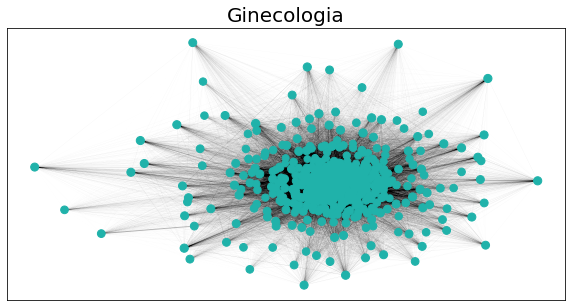

In [8]:
gin_graph = build_graph(gin_table, ginecologia)
plot_network(gin_graph, "Ginecologia", False)

### Atributos

In [11]:
def statistics(graph):
    n_edges = len(graph.edges())
    n_nodes = len(graph.nodes())

    print("Numero de arestas:", n_edges)
    print("Numero de nos:", n_nodes)
    print("Media de arestas/nos", n_edges/n_nodes)
    print("Número de componentes: ", nx.number_connected_components(graph))
    
    degrees = dict(graph.degree())
    avg_deg = np.mean(list(degrees.values()))
    print("Grau Medio:", avg_deg)
    
    primeiro_momento = momment_of_degree_distribution(graph, 1)
    segundo_momento = momment_of_degree_distribution(graph, 2)

    variancia = segundo_momento - primeiro_momento**2

    print("Variancia: ", variancia)
    desvio_amostral = (variancia*len(graph)/(len(graph)-1))**0.5
    print("Desvio amostral :", desvio_amostral/(len(graph)**0.5)*1.96)
    
    transitivity = nx.transitivity(graph)
    rd_transitivity = avg_deg/len(graph)

    print("Transitivity:", transitivity)
    print("Random graph transitivity:", rd_transitivity)
    print("Ratio:", transitivity/rd_transitivity)
    print("Average cluestring:", nx.average_clustering(graph))


def degree_distribution(graph, title=None):
    degrees = dict(graph.degree())

    deg_dist = dict()

    for node, degree in degrees.items():
        if degree in deg_dist:
            deg_dist[degree] += 1
        else:
            deg_dist[degree] = 1

    keys = list(deg_dist.keys())
    Pk = list(deg_dist.values())
    Pk = [i/sum(Pk) for i in Pk]

    fig = plt.subplot(1,1,1)
    plt.plot(keys, Pk,'bo')
    plt.xlabel("k", fontsize=20)
    plt.ylabel("P(k)", fontsize=20)
    plt.title("Distribuição de Grau", fontsize=20)
    
    if title:
        plt.savefig("Images/{}".format(title))
    plt.show()

In [14]:
statistics(gin_graph)

Numero de arestas: 61115
Numero de nos: 715
Media de arestas/nos 85.47552447552448
Número de componentes:  1
Grau Medio: 170.95104895104896
Variancia:  21879.42837302557
Desvio amostral : 10.849880405555952
Transitivity: 0.5281345090339109
Random graph transitivity: 0.23909237615531323
Ratio: 2.2089140504038376
Average cluestring: 0.8190275561518511


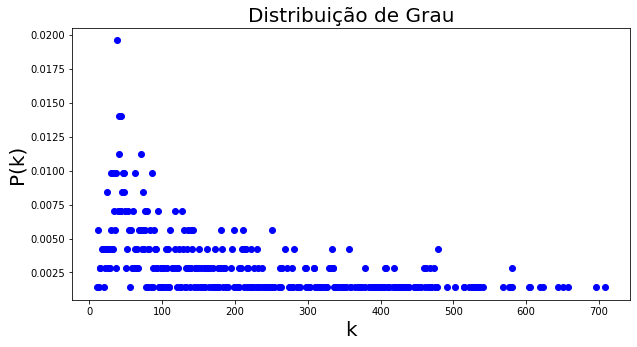

In [26]:
degree_distribution(gin_graph)

### Detecção de comunidades

In [15]:
gin_communities = community.best_partition(gin_graph, random_state=SEED)
modularity = community.modularity(gin_communities, gin_graph)
print("Modularidade :", modularity)

Modularidade : 0.5480495235638122


In [16]:
gin_communities = community.best_partition(gin_graph, partition=gin_communities, random_state=SEED)
modularity = community.modularity(gin_communities, gin_graph)
print("Modularidade :", modularity)

Modularidade : 0.548695901706328


In [31]:
inv_com = community_distribution(gin_communities)

Comunidade 0 : 118
Comunidade 1 : 97
Comunidade 2 : 81
Comunidade 3 : 59
Comunidade 4 : 27
Comunidade 5 : 43
Comunidade 6 : 28
Comunidade 7 : 20
Comunidade 8 : 13
Comunidade 9 : 16
Comunidade 10 : 12
Comunidade 11 : 11
Comunidade 12 : 6
Comunidade 13 : 20
Comunidade 14 : 7
Comunidade 15 : 9
Comunidade 16 : 7
Comunidade 17 : 8
Comunidade 18 : 6
Comunidade 19 : 8
Comunidade 20 : 22
Comunidade 21 : 12
Comunidade 22 : 1
Comunidade 23 : 1
Comunidade 24 : 3
Comunidade 25 : 1
Comunidade 26 : 4
Comunidade 27 : 8
Comunidade 28 : 1
Comunidade 29 : 1
Comunidade 30 : 1
Comunidade 31 : 1
Comunidade 32 : 1
Comunidade 33 : 2
Comunidade 34 : 1
Comunidade 35 : 1
Comunidade 36 : 1
Comunidade 37 : 1
Comunidade 38 : 9
Comunidade 39 : 1
Comunidade 40 : 3
Comunidade 41 : 1
Comunidade 42 : 1
Comunidade 43 : 2
Comunidade 44 : 1
Comunidade 45 : 1
Comunidade 46 : 2
Comunidade 47 : 1
Comunidade 48 : 1
Comunidade 49 : 1
Comunidade 50 : 1
Comunidade 51 : 1
Comunidade 52 : 1
Comunidade 53 : 2
Comunidade 54 : 1
Comu

[0.         0.58227848 0.65822785 0.6835443  0.69620253 0.69620253
 0.72151899 0.74683544 0.78481013 0.81012658 0.81012658 0.82278481
 0.84810127 0.86075949 0.86075949 0.86075949 0.87341772 0.87341772
 0.87341772 0.87341772 0.89873418 0.89873418 0.91139241 0.91139241
 0.91139241 0.91139241 0.91139241 0.92405063 0.93670886 0.93670886
 0.93670886 0.93670886 0.93670886 0.93670886 0.93670886 0.93670886
 0.93670886 0.93670886 0.93670886 0.93670886 0.93670886 0.93670886
 0.93670886 0.94936709 0.94936709 0.94936709 0.94936709 0.94936709
 0.94936709 0.94936709 0.94936709 0.94936709 0.94936709 0.94936709
 0.94936709 0.94936709 0.94936709 0.94936709 0.94936709 0.96202532
 0.96202532 0.96202532 0.96202532 0.96202532 0.96202532 0.96202532
 0.96202532 0.96202532 0.96202532 0.96202532 0.96202532 0.96202532
 0.96202532 0.96202532 0.96202532 0.96202532 0.96202532 0.96202532
 0.96202532 0.96202532 0.96202532 0.97468354 0.97468354 0.97468354
 0.97468354 0.97468354 0.97468354 0.97468354 0.97468354 0.9746

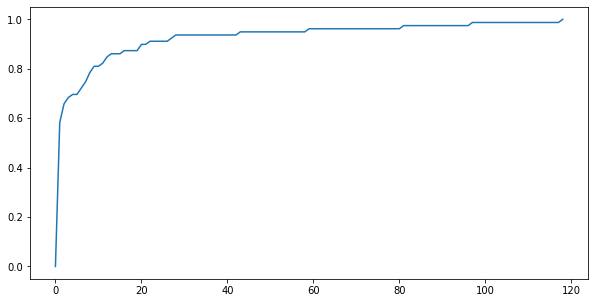

In [59]:
pct = dict()
for com, product in inv_com.items():
    size = len(product)
    if size in pct:
        pct[size] += 1
    else:
        pct[size] = 1

max_size = max(pct.keys())
counting = np.zeros(max_size+1)

for size, qnt in pct.items():
    counting[size] = qnt

# Função acumulada
for i in range(1, len(counting)):
    counting[i] += counting[i-1]

counting = counting/counting[-1]

print(counting)

plt.plot(counting)
plt.show()

### Aproveitamento

In [20]:
usage = community_usage(gin_table, gin_communities)
usage

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,Media
66994,0.305085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.305085
100356,0.169492,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096374
64687,0.313559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.313559
81395,0.355932,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183121
80840,0.203390,0.309278,0.024691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70669,0.076271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076271
102064,0.050847,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037052
71794,0.042373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0

### Subcomunidades

In [86]:
def build_small_communities(communities, network): 
    small_communities = dict()
    
    communities_map = community_distribution(communities, False)

    for com in communities_map:
        nodes = communities_map[com]
        if len(nodes) / len(network) > 0.02:
            sub_graph = network.subgraph(nodes)

            print("Novas subcomunidades:", com, len(nodes))
            sub_partition = community.best_partition(sub_graph)
            g = community_distribution(sub_partition)
            small_communities[com] = sub_partition

            print("-------------------------")
            
    return small_communities

In [87]:
gin_small_communities = build_small_communities(gin_communities, gin_graph)

Novas subcomunidades: 0 118
Comunidade 0 : 2
Comunidade 1 : 24
Comunidade 2 : 15
Comunidade 3 : 4
Comunidade 4 : 28
Comunidade 5 : 4
Comunidade 6 : 33
Comunidade 7 : 7
Comunidade 8 : 1
-------------------------
Novas subcomunidades: 1 97
Comunidade 0 : 13
Comunidade 1 : 4
Comunidade 2 : 2
Comunidade 3 : 3
Comunidade 4 : 6
Comunidade 5 : 3
Comunidade 6 : 2
Comunidade 7 : 15
Comunidade 8 : 8
Comunidade 9 : 7
Comunidade 10 : 3
Comunidade 11 : 2
Comunidade 12 : 8
Comunidade 13 : 3
Comunidade 14 : 4
Comunidade 15 : 3
Comunidade 16 : 2
Comunidade 17 : 3
Comunidade 18 : 2
Comunidade 19 : 1
Comunidade 20 : 1
Comunidade 21 : 2
-------------------------
Novas subcomunidades: 2 81
Comunidade 0 : 5
Comunidade 1 : 3
Comunidade 2 : 10
Comunidade 3 : 1
Comunidade 4 : 9
Comunidade 5 : 5
Comunidade 6 : 6
Comunidade 7 : 2
Comunidade 8 : 3
Comunidade 9 : 2
Comunidade 10 : 10
Comunidade 11 : 8
Comunidade 12 : 4
Comunidade 13 : 6
Comunidade 14 : 3
Comunidade 15 : 2
Comunidade 16 : 1
Comunidade 17 : 1
-----

In [88]:
merged_com = merge_subcommunities(gin_communities, gin_small_communities)

In [90]:
sub_com_usage = community_usage(gin_table, merged_com)
sub_com_usage

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,Media
66994,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.833333,0.066667,0.250000,0.000000,0.000000,0.333333,0.285714,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000,0.0,0.000000,0.00,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.461508
100356,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.416667,0.066667,0.000000,0.178571,0.000000,0.060606,0.142857,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000,0.0,0.000000,0.00,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.314100
64687,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [91]:
inv_com = community_distribution(merged_com)

Comunidade 0 : 13
Comunidade 1 : 12
Comunidade 2 : 11
Comunidade 3 : 6
Comunidade 4 : 7
Comunidade 5 : 9
Comunidade 6 : 7
Comunidade 7 : 8
Comunidade 8 : 6
Comunidade 9 : 8
Comunidade 10 : 12
Comunidade 11 : 1
Comunidade 12 : 1
Comunidade 13 : 3
Comunidade 14 : 1
Comunidade 15 : 4
Comunidade 16 : 8
Comunidade 17 : 1
Comunidade 18 : 1
Comunidade 19 : 1
Comunidade 20 : 1
Comunidade 21 : 1
Comunidade 22 : 2
Comunidade 23 : 1
Comunidade 24 : 1
Comunidade 25 : 1
Comunidade 26 : 1
Comunidade 27 : 9
Comunidade 28 : 1
Comunidade 29 : 3
Comunidade 30 : 1
Comunidade 31 : 1
Comunidade 32 : 2
Comunidade 33 : 1
Comunidade 34 : 1
Comunidade 35 : 2
Comunidade 36 : 1
Comunidade 37 : 1
Comunidade 38 : 1
Comunidade 39 : 1
Comunidade 40 : 1
Comunidade 41 : 1
Comunidade 42 : 2
Comunidade 43 : 1
Comunidade 44 : 2
Comunidade 45 : 1
Comunidade 46 : 1
Comunidade 47 : 1
Comunidade 48 : 2
Comunidade 49 : 1
Comunidade 50 : 1
Comunidade 51 : 1
Comunidade 52 : 1
Comunidade 53 : 1
Comunidade 54 : 1
Comunidade 55 : 

[0.         0.53174603 0.71825397 0.80952381 0.8531746  0.86507937
 0.88492063 0.90873016 0.94047619 0.95238095 0.96031746 0.96428571
 0.97222222 0.98015873 0.98015873 0.98809524 0.98809524 0.98809524
 0.98809524 0.98809524 0.98809524 0.98809524 0.98809524 0.98809524
 0.99206349 0.99206349 0.99206349 0.99206349 0.99603175 0.99603175
 0.99603175 0.99603175 0.99603175 1.        ]


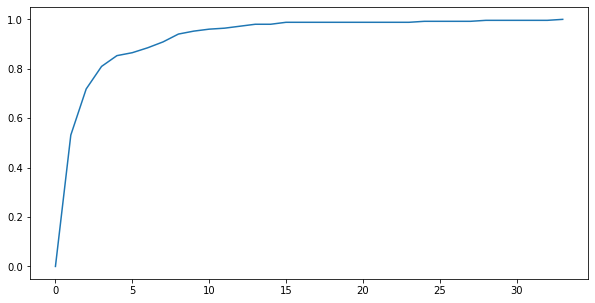

In [92]:
pct = dict()
for com, product in inv_com.items():
    size = len(product)
    if size in pct:
        pct[size] += 1
    else:
        pct[size] = 1

max_size = max(pct.keys())
counting = np.zeros(max_size+1)

for size, qnt in pct.items():
    counting[size] = qnt

# Função acumulada
for i in range(1, len(counting)):
    counting[i] += counting[i-1]

counting = counting/counting[-1]

print(counting)

plt.plot(counting)
plt.show()

# TODO

    - padronizar/acertar gráficos + legendas
        - Grafo representado as comunidades pode apresentar mais informações:
            * cor da aresta proporcional ao peso
            * tamanho do no proporcional ao tamanho da comunidade
    - modularizar funções
    - Repetir multiplas vezes a formação de comunidades uma vez que é aleatorio??? -> acho q nao, mas vale a pena dar uma olhadinha no quanto varia
    
    - Até quando é interessante atomizar os kits?????

## Análise exploratória

Iremos levantar estatísticas simples sobre a base dados com o objetivo de enteder melhor suas informações. Essa análise tentará responder algumas simples perguntas.

### Convênios

Iremos avaliar a distribuição dos convênios e sua relação com as cirurgias realizadas.

#### Distribuição do Convênios

In [40]:
convenios_cnt = dataset["NM_CONVENIO"].value_counts()
print(tabulate(convenios_cnt.to_frame(), headers=["Convenios", "Contagem"], tablefmt='psql'))

+-----------------------------------+------------+
| Convenios                         |   Contagem |
|-----------------------------------+------------|
| SUS - INTERNACAO                  |     355032 |
| UNIMED                            |     198237 |
| PARTICULAR                        |      68828 |
| SAO FRANCISCO                     |      57943 |
| SUS - AMBULATORIO                 |      12570 |
| BRADESCO SAUDE S.A.               |       2975 |
| CASSI                             |       1706 |
| AMIL                              |       1366 |
| SUL AMERICA                       |       1026 |
| PORTO SEGURO                      |        325 |
| GEAP                              |        306 |
| AMIL - INATIVO                    |        160 |
| MEDISERVICE                       |        151 |
| CABESP                            |         71 |
| HOSPITAU                          |         37 |
| AMBULATORIO CLINICAS - PARTICULAR |          8 |
+------------------------------

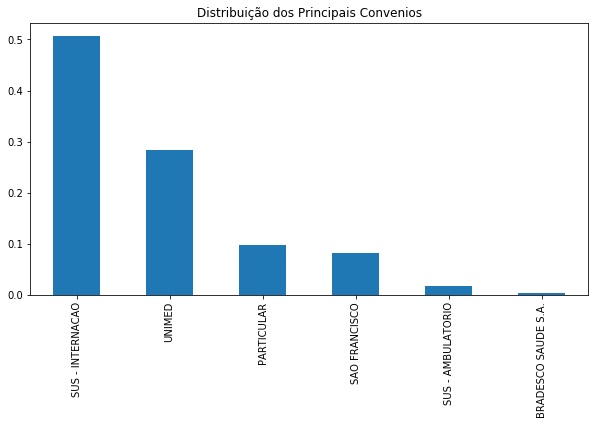

In [41]:
# Convertendo para valor percentual
conv_freq = convenios_cnt/len(dataset)

# Selecionar os mais significativos
conv_freq = conv_freq[conv_freq > 0.0025]

# Plotar
conv_freq.plot.bar(title="Distribuição dos Principais Convenios")
plt.show()

Porcentagem dos atendimentos particulares e públicos

In [42]:
sus_pct = conv_freq["SUS - INTERNACAO"] + conv_freq["SUS - AMBULATORIO"]
print("SUS :", sus_pct)
print("Particular :", 1-sus_pct)


SUS : 0.5245903978788169
Particular : 0.4754096021211831


#### Operações por convênio

Número de cirurgias distintas realizadas no hospital: 1088


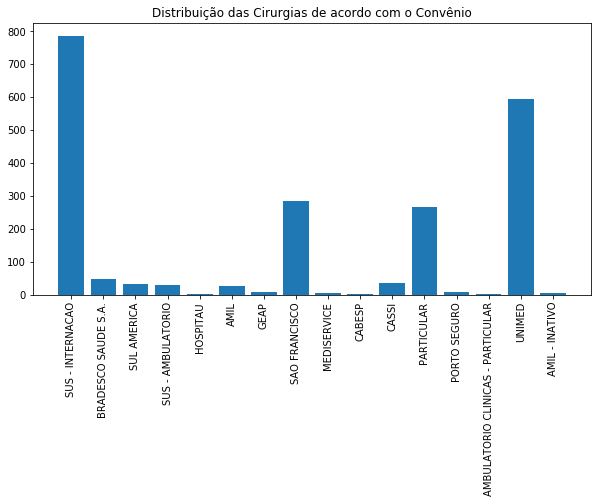

In [43]:
# Guardanado convenios e operacoes
convenios = set(dataset["NM_CONVENIO"].unique())
operacoes = set(dataset["CD_CIRURGIA"].unique())

# Separando as operacoes por convenio
op_conv = dict()
for conv in convenios:
    op = dataset[dataset["NM_CONVENIO"] == conv]
    op_conv[conv] = set(op["CD_CIRURGIA"].unique())

op_conv_dist = {}
for conv in op_conv:
    op_conv_dist[conv] = len(op_conv[conv]) 

print("Número de cirurgias distintas realizadas no hospital:", len(operacoes))
plt.bar(range(len(op_conv_dist)), list(op_conv_dist.values()), align='center')
plt.xticks(range(len(op_conv_dist)), list(op_conv_dist.keys()), rotation="vertical")
plt.title("Distribuição das Cirurgias de acordo com o Convênio")
plt.show()

Existem diferenças significativas entre as operações oferecidas a pacientes conveniados ou encaminhados pelo SUS? 

In [44]:
temp = list()
for conv in op_conv:
    temp.append((conv, len(operacoes-op_conv[conv])))

print(tabulate(temp, headers=["Convenio", "# Operacoes nao realizadas"], tablefmt='psql'))
    
print("SUS", len(operacoes - op_conv["SUS - AMBULATORIO"] - op_conv["SUS - INTERNACAO"]))

+-----------------------------------+------------------------------+
| Convenio                          |   # Operacoes nao realizadas |
|-----------------------------------+------------------------------|
| SUS - INTERNACAO                  |                          302 |
| BRADESCO SAUDE S.A.               |                         1041 |
| SUL AMERICA                       |                         1057 |
| SUS - AMBULATORIO                 |                         1059 |
| HOSPITAU                          |                         1087 |
| AMIL                              |                         1062 |
| GEAP                              |                         1080 |
| SAO FRANCISCO                     |                          805 |
| MEDISERVICE                       |                         1083 |
| CABESP                            |                         1087 |
| CASSI                             |                         1053 |
| PARTICULAR                      

Sem realizar distinções entre as operação, o SUS é reponsável por cerca de 50% das operações. Existem cerca de 300 operações que não são realizdas pelo sistema único, o que comparado com os principais convênios, representa um número baixo.

### Cirurgias

Iremos avaliar as especialidades mais comuns e as cirurgias realizadas.

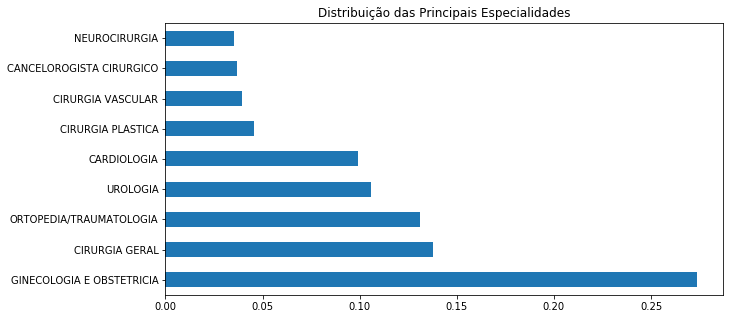

In [45]:
# Conjunto de especialidades
especialidades = set(dataset["DS_ESPECIALID"].unique())

# Distribuicao de acordo com as especialidades
especialidades_dist = dataset["DS_ESPECIALID"].value_counts()
especialidades_dist = especialidades_dist/len(dataset)
especialidades_dist = especialidades_dist[especialidades_dist > 0.025]

# Plotar
especialidades_dist.plot.barh(title="Distribuição das Principais Especialidades")
plt.show()

In [46]:
# Distribuicao de acordo com as especialidades
especialidades_cnt = dataset["DS_ESPECIALID"].value_counts()
ep = especialidades_cnt
print(tabulate(especialidades_cnt.to_frame(), headers=["Especialidade", "Contagem"], tablefmt='psql'))


+--------------------------------+------------+
| Especialidade                  |   Contagem |
|--------------------------------+------------|
| GINECOLOGIA E OBSTETRICIA      |     191719 |
| CIRURGIA GERAL                 |      96446 |
| ORTOPEDIA/TRAUMATOLOGIA        |      91942 |
| UROLOGIA                       |      74227 |
| CARDIOLOGIA                    |      69366 |
| CIRURGIA PLASTICA              |      31803 |
| CIRURGIA VASCULAR              |      27633 |
| CANCELOROGISTA CIRURGICO       |      25722 |
| NEUROCIRURGIA                  |      24902 |
| CIRURGIA CARDIOVASCULAR        |      13182 |
| CIRURGIA PEDIATRICA            |       9555 |
| OTORRINOLARINGOLOGIA           |       8871 |
| ODONTOLOGIA C.TRAUM.B.M.F.     |       6711 |
| MASTOLOGIA                     |       5174 |
| CIRURGIA CABECA E PESCOCO      |       3752 |
| ANESTESIOLOGIA                 |       3679 |
| MEDICINA FISICA                |       3226 |
| CIRURGIA APARELHO DIGESTIVO    |      

In [47]:
gine = dataset[dataset["DS_ESPECIALID"] == "GINECOLOGIA E OBSTETRICIA"]
# op_gine = set(gine["DS_CIRURGIA"].unique())
# op_gine_cnt = gine["DS_CIRURGIA"].value_counts()

# cesariana_feto_mult = gine[gine["DS_CIRURGIA"] == "CESARIANA - FETO MULTIPLO"]
# # print(cesariana["CD_CID"].value_counts())
# ces_eletiva = cesariana_feto_mult[cesariana_feto_mult["CD_CID"] == "O820"]

quat_cinc = dataset[dataset["DT_REALIZACAO"] == "08/05/17 14:30:00"]
# quat_cinc
quat_cinc = dataset[dataset["DT_REALIZACAO"] == "08/05/17 14:30:00"]

In [48]:
gine = dataset[dataset["DS_ESPECIALID"] == "GINECOLOGIA E OBSTETRICIA"]
op_gine = set(gine["DS_CIRURGIA"].unique())
op_gine_cnt = gine["DS_CIRURGIA"].value_counts()

op_gine_cnt

CESARIANA - FETO MULTIPLO                                          87332
CESARIANA - FETO UNICO                                             48744
PARTO NORMAL                                                       22893
HISTERECTOMIA ABDOMINAL                                             7111
CURETAGEM POS ABORTO                                                7092
                                                                   ...  
ENDOMETRIOMA DE PAREDE                                                19
LAPAROSCOPIA CIRURGICA PARA LISE DE ADERENCIA OU LISE DE BRIDAS       19
RETIRADA DE CERCLAGEM DO COLO UTERINO                                 15
HIMENOTOMIA                                                           14
CORDOCENTESE                                                           8
Name: DS_CIRURGIA, Length: 75, dtype: int64

In [49]:
op_zero = dataset["CD_ESPECIE"].unique()
len(op_zero)

7